# Part 2 solutions (don't peek!)

_(Solutions for [Part 2 project](project.ipynb).)_

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.tree
import matplotlib
import matplotlib.pyplot as plt

## Re-evaluating the inputs

In [2]:
X1, y1 = sklearn.datasets.make_gaussian_quantiles(
    cov=2.0, n_samples=500, n_features=2, n_classes=2, random_state=1
)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=1000, n_features=2, n_classes=2, random_state=1
)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

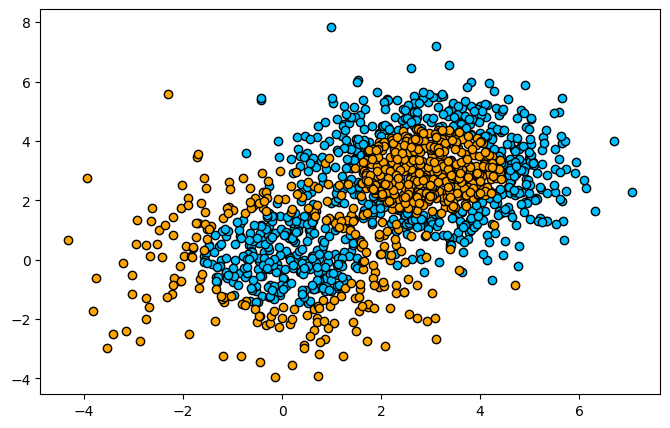

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black");
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black");

In [4]:
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
def predict_single(position, tree, array_index=0):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        if position[feature] <= threshold:
            return predict_single(position, tree, left_index)
        else:
            return predict_single(position, tree, right_index)

    else:
        return np.argmax(tree.value[array_index], axis=1)

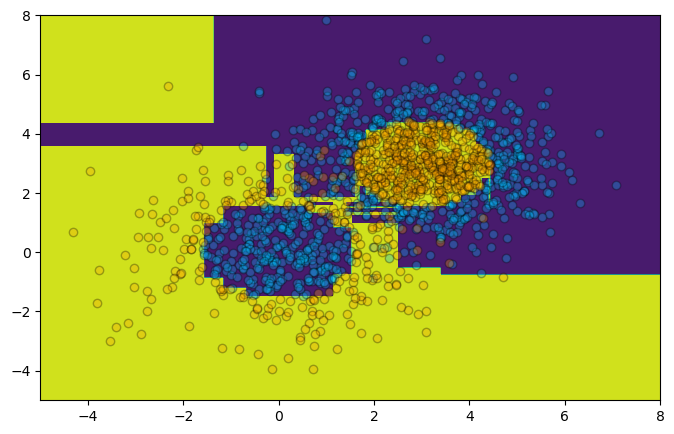

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    [predict_single(position, decision_tree.tree_) for position in np.c_[xx.ravel(), yy.ravel()]]
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

<br><br><br>

## THE SOLUTION (purely immutable)

Let's approach this problem in small steps. We want to walk down the tree, first by taking a single step.

But it's a single step for each input, and each of them may step in different directions.

To figure out which way each one steps, we'll need to know what features each one sees, what thresholds each one sees, which index goes to the left and right children for each, etc.

In [7]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

In [8]:
decision_tree.tree_.feature[array_indexes]

array([1, 1, 1], dtype=int64)

In [9]:
decision_tree.tree_.threshold[array_indexes]

array([4.36631989, 4.36631989, 4.36631989])

In [10]:
decision_tree.tree_.children_left[array_indexes]

array([1, 1, 1], dtype=int64)

In [11]:
decision_tree.tree_.children_right[array_indexes]

array([134, 134, 134], dtype=int64)

At first, they all see the same values because they're all at `array_indexes[_] == 0`, the root of the tree.

If I were to (ad hoc) decide that the first should go left and the other two go right...

In [12]:
array_indexes = np.array([1, 136, 136], np.int64)

In [13]:
decision_tree.tree_.feature[array_indexes]

array([1, 1, 1], dtype=int64)

In [14]:
decision_tree.tree_.threshold[array_indexes]

array([1.71515965, 4.41564059, 4.41564059])

In [15]:
decision_tree.tree_.children_left[array_indexes]

array([  2, 137, 137], dtype=int64)

In [16]:
decision_tree.tree_.children_right[array_indexes]

array([ 69, 146, 146], dtype=int64)

Now we're getting different results for the different array indexes.

Array-wise, the ones that have children are

```python
have_children = tree.children_left[array_indexes] >= 0
```

and the ones that will be choosing left are

```python
choosing_left = positions[np.arange(len(positions)), features] <= thresholds
```

This second expression probably needs some explanation. (It was the first "hint.") It is a two-dimensional slice in which we take every member of the first dimension, in order, and feature `0` or `1` of the second dimension, as determined by the `features` array.

Here's a small example.

In [17]:
positions = np.array([
    [0.0, 0.0], [0.1, 1.1], [0.2, 2.2], [0.3, 3.3], [0.4, 4.4],
    [0.5, 5.5], [0.6, 6.6], [0.7, 7.7], [0.8, 8.8], [0.9, 9.9],
])

In [18]:
np.arange(len(positions))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
features = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

positions[np.arange(len(positions)), features]

array([0. , 1.1, 0.2, 3.3, 0.4, 5.5, 0.6, 7.7, 0.8, 9.9])

<br><br><br>

You didn't have to do it this way! It works just as well if every element of the first dimension's slice is `True`.

In [20]:
np.ones(len(positions), np.bool_)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [21]:
positions[np.ones(len(positions), np.bool_), features]

array([0. , 1.1, 0.2, 3.3, 0.4, 5.5, 0.6, 7.7, 0.8, 9.9])

But I thought that the integer form would be more self-explanatory.

<br><br><br>

Now that you know which indexes will be choosing left, you need to return an updated `array_indexes` in which those select from the `left_indexes` and the others select from the `right_indexes`. The second hint pointed to [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html).

In [22]:
choosing_left = np.array([True, False, True, False, True, False, True, False, True])

left_indexes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
right_indexes = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])

np.where(choosing_left, left_indexes, right_indexes)

array([ 1, 20,  3, 40,  5, 60,  7, 80,  9])

<br><br><br>

But we're not done: some of the nodes don't have children. The negative values for those `left_indexes` and `right_indexes` will go to another position in the array, but `-1` goes to the last position—not what we want.

We want the nodes that have reached leaves to stay at those leaves, replacing $X$ with $X$ (i.e. no visible change). This was the third hint.

```python
have_children = tree.children_left[array_indexes] >= 0

np.where(have_children, np.where(choosing_left, left_indexes, right_indexes), array_indexes)
```

<br><br><br>

Putting this all together,

In [23]:
def predict_many_step(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0

    features = tree.feature[array_indexes]
    thresholds = tree.threshold[array_indexes]
    left_indexes = tree.children_left[array_indexes]
    right_indexes = tree.children_right[array_indexes]

    choosing_left = positions[np.arange(len(positions)), features] <= thresholds

    return np.where(have_children, np.where(choosing_left, left_indexes, right_indexes), array_indexes)

<br><br><br>

The above function moves all `array_indexes` to their next value, even if that value is a leaf.

In [24]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

If you evaluate the next cell enough times, the `array_indexes` will stop changing.

In [25]:
array_indexes = predict_many_step(positions, decision_tree.tree_, array_indexes)
array_indexes

array([1, 1, 1], dtype=int64)

Some stop changing before others because they reach their leaves before the others are done.

<br><br><br>

How many times do we need to evaluate that function until we know that everything should stop?

In [26]:
decision_tree.tree_.max_depth

10

So it is sufficient to call `predict_many_step`, replacing `array_indexes`, 10 times. Any more wouldn't change anything because all of the `array_indexes` have reached their stopping positions on leaves.

<br><br><br>

Putting this all together, the final `predict_many` function is

In [27]:
def predict_many(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        array_indexes = predict_many_step(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(tree.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [28]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many(positions, decision_tree.tree_)

array([1, 0, 1])

(There's a variety of ways to get the `leaf_decisions` from `tree.value`. Iteratively tinkering with indexing until you get what you want, on a large and diverse enough sample, is a good way to derive such expressions.)

Interesting to note: this function is _not_ recursive.

<br><br><br>

Now we can make a plot with `predict_many`:

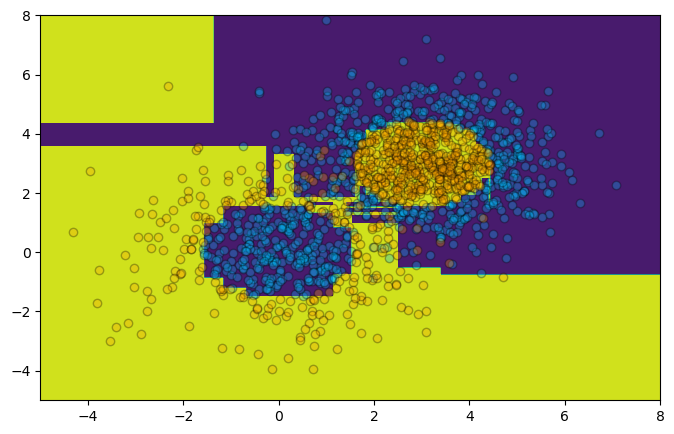

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

And it's much faster than calling `predict_single` many times.

<br><br><br>

## THE SOLUTION (modify in-place)

As I said in the statement of the exercise, it's possible to solve this by changing arrays in place, rather than creating new arrays with functions like `np.where`.

This is a matter of degree. You could do some of the steps by in-place modification and others in immutable steps.

I'd say that it is _much easier_ to perform calculations in immutable steps. When you change things in place, you really need to know which arrays are views (a.k.a. [aliasing](https://en.wikipedia.org/wiki/Aliasing_(computing))) and which are unlinked/new data buffers. NumPy's naming convention does not help us know which is which (the way that PyTorch's trailing underscore convention does). In-place modification is often faster, but I'll show you a counterexample below.

Here is an implementation that uses as much in-place modification as I could find opportunities for.

In [30]:
def predict_many_step_inplace(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0
    array_indexes_with_children = array_indexes[have_children]
    
    features = tree.feature[array_indexes_with_children]
    thresholds = tree.threshold[array_indexes_with_children]
    left_indexes = tree.children_left[array_indexes_with_children]
    right_indexes = tree.children_right[array_indexes_with_children]

    choosing_left = positions[have_children, features] <= thresholds

    # change the right indexes for which we are choosing left into the corresponding left indexes
    # (it's not linked to the original tree.children_right)
    right_indexes[choosing_left] = left_indexes[choosing_left]

    # and now right_indexes is the right thing to change in the array_indexes
    array_indexes[have_children] = right_indexes

It works the same way.

In [31]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

Evaluate the next cell until `array_indexes` stops changing.

In [32]:
predict_many_step_inplace(positions, decision_tree.tree_, array_indexes)
array_indexes

array([1, 1, 1])

<br><br><br>

The `predict_many_inplace` function is mostly like the `predict_many` function, except that it doesn't have to reassign `array_indexes`. That happens inside `predict_many_step_inplace`.

In [33]:
def predict_many_inplace(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        predict_many_step_inplace(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(decision_tree.tree_.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [34]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many_inplace(positions, decision_tree.tree_)

array([1, 0, 1])

<br><br><br>

Here's the final plot.

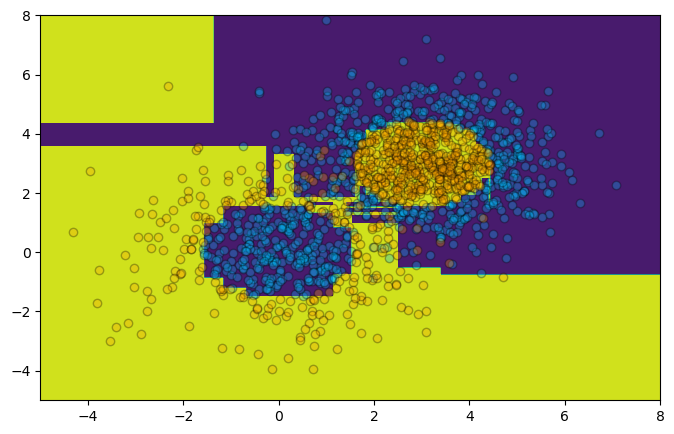

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_inplace(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

<br><br><br>

## Performance comparison

So, which one's faster?

In [36]:
prepared_data = np.c_[xx.ravel(), yy.ravel()]

The original Scikit-Learn function?

In [37]:
%%timeit -o

decision_tree.predict(prepared_data).reshape(xx.shape)

11.5 ms ± 156 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 11.5 ms ± 156 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [38]:
result_scikit_learn = _

The single tree-at-a-time Python function?

In [39]:
%%timeit -o

[predict_single(position, decision_tree.tree_) for position in prepared_data]

6.3 s ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 6.3 s ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [40]:
result_python = _

The array-oriented NumPy function with immutable arrays?

In [41]:
%%timeit -o

predict_many(prepared_data, decision_tree.tree_)

66.2 ms ± 280 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 66.2 ms ± 280 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [42]:
result_numpy = _

The array-oriented NumPy function with in-place modification?

In [43]:
%%timeit -o

predict_many_inplace(prepared_data, decision_tree.tree_)

58.8 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 58.8 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [44]:
result_numpy_inplace = _

Naturally, Scikit-Learn has the most highly-tuned implementation. Pure Python is a disaster (note the different units), and the NumPy implementations are barely within an order of magnitude of the Scikit-Learn one.

First objection: many of Scikit-Learn's algorithms are precompiled, in C++ or Cython. None of the implementations written in Python _would_ come close to that.

<br><br><br>

### Compiled single-tree traversal

[Numba](https://numba.pydata.org/) is a compiler of (a subset of) Python code. It has a static typing discipline, so most code decorated with `@nb.njit` runs at the speed of compiled C code.

We can put the single-traversal implementation in Numba, but we have to pass `decision_tree.tree_`'s arrays in manually. Numba recognizes NumPy arrays, but not `sklearn.tree._tree.Tree` objects.

In [45]:
import numba as nb

In [46]:
@nb.njit
def predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, array_index=0):
    has_children = tree_children_left[array_index] >= 0

    if has_children:
        feature = tree_feature[array_index]
        threshold = tree_threshold[array_index]
        left_index = tree_children_left[array_index]
        right_index = tree_children_right[array_index]

        if position[feature] <= threshold:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, left_index)
        else:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, right_index)

    else:
        return np.argmax(tree_value[array_index])

The single-tree traversals are independent, so they can be computed in parallel (and need to be for a fair comparison with JAX, below).

[nb.prange](https://numba.pydata.org/numba-doc/latest/user/parallel.html#explicit-parallel-loops) is like Python's `range` except that it allows Numba to execute the loop body for different `index` values in parallel. `parallel=True` is also necessary in `@nb.njit`.

In [47]:
@nb.njit(parallel=True)
def predict_many_numba(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    out = np.empty(len(positions), np.int64)
    for index in nb.prange(len(positions)):
        position = positions[index]
        out[index] = predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value)
    return out

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


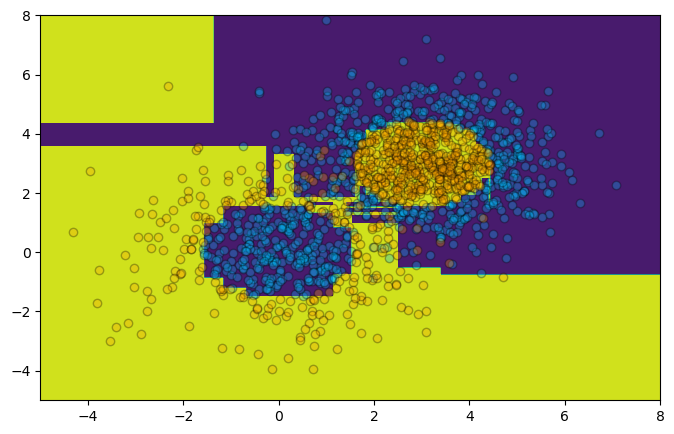

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_numba(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [49]:
%%timeit -o

predict_many_numba(
    prepared_data,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

24.9 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 24.9 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [50]:
result_numba = _

Several things are speeding up this implementation:

  * it's compiled
  * operations are fused, allowing for fewer passes over the data than NumPy
  * it's running in parallel, on all available cores

With all of that, it's _almost_ as fast as the Scikit-Learn implementation.

But the code is not array-oriented. Is array-oriented code doomed to be slower than imperative code?

<br><br><br>

### Compiled array-oriented traversal

Whereas Numba compiles imperative, `for` loop like code, [JAX](http://jax.readthedocs.io/) compiles array-oriented code.

Numba examines your function, including all branches of every `if` statement and `for`/`while` loops that iterate a dynamic number of times, and replaces it with a compiled version of the same (through LLVM).

JAX _walks_ through your function, and every operation that is performed on variables derived from the function arguments are logged for future compilation. A _walk_ through your code can only follow one branch of an `if` statement and can only go through `for`/`while` if the number of loops is a compile-time constant. Also, arrays must always be immutable: no changing in-place is allowed. It's a more restrictive programming environment, but the compiler does amazing things within those restrictions.

Here's a `@jax.jit` of the immutable, array-oriented code.

In [51]:
import jax
jax.config.update("jax_platform_name", "cpu"); 
jax.config.update("jax_enable_x64", True)

In [52]:
def predict_many_step_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes):
    have_children = tree_children_left[array_indexes] >= 0

    features = tree_feature[array_indexes]
    thresholds = tree_threshold[array_indexes]
    left_indexes = tree_children_left[array_indexes]
    right_indexes = tree_children_right[array_indexes]

    choosing_left = positions[jax.numpy.arange(len(positions)), features] <= thresholds

    return jax.numpy.where(have_children, jax.numpy.where(choosing_left, left_indexes, right_indexes), array_indexes)

def predict_many_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    array_indexes = jax.numpy.zeros(len(positions), np.int64)

    for iteration in range(decision_tree.tree_.max_depth):
        array_indexes = predict_many_step_jax(
            positions,
            tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes,
        )
    
    leaf_decisions = jax.numpy.argmax(tree_value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

predict_many_jax = jax.jit(predict_many_jax, backend="cpu")

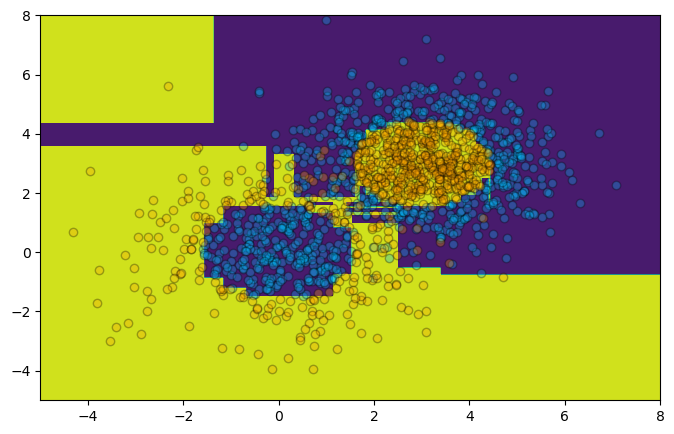

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_jax(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [54]:
%%timeit -o

predict_many_jax(
    prepared_data,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

6.74 ms ± 680 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 6.74 ms ± 680 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [55]:
result_jax = _

Astonishingly (to me), JAX beats both Numba and is on-par with the Scikit-Learn implementation. The JAX compiler is able to take advantage of the high-level array operations and produce the fastest implementation available.

Note: we're running on CPUs (in parallel), not a GPU. But being array-oriented code, it's GPU-ready.

<br><br><br>

### The results

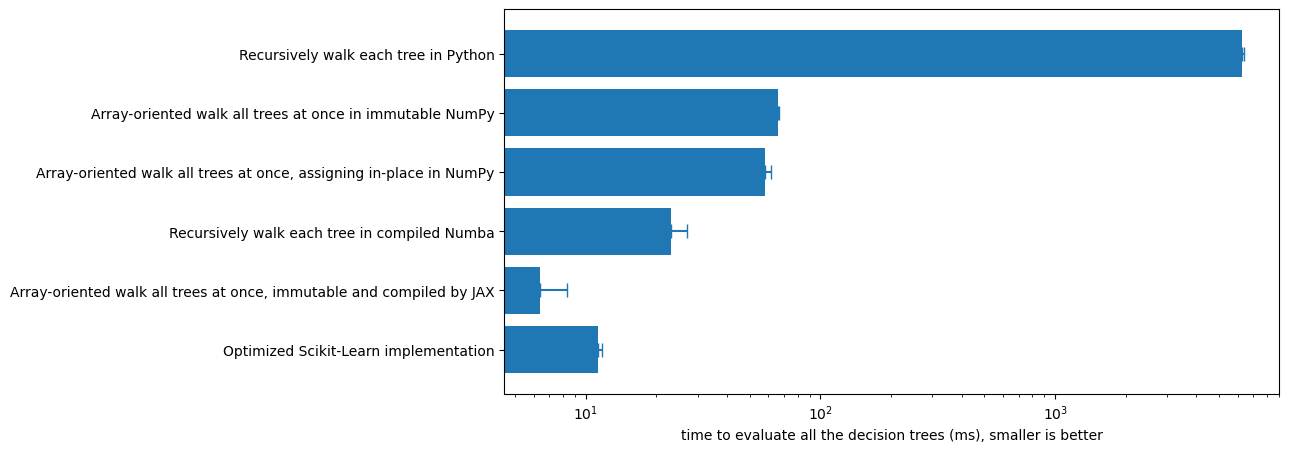

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))

test_names = [
    'Recursively walk each tree in Python',
    'Array-oriented walk all trees at once in immutable NumPy',
    'Array-oriented walk all trees at once, assigning in-place in NumPy',
    'Recursively walk each tree in compiled Numba',
    'Array-oriented walk all trees at once, immutable and compiled by JAX',
    'Optimized Scikit-Learn implementation',
][::-1]
test_results = np.array([
    1e3 * np.min(result_python.all_runs) / result_python.loops,
    1e3 * np.min(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.min(result_numpy_inplace.all_runs) / result_numpy_inplace.loops,
    1e3 * np.min(result_numba.all_runs) / result_numba.loops,
    1e3 * np.min(result_jax.all_runs) / result_jax.loops,
    1e3 * np.min(result_scikit_learn.all_runs) / result_scikit_learn.loops,
][::-1])
test_variations = np.array([
    1e3 * np.ptp(result_python.all_runs) / result_python.loops,
    1e3 * np.ptp(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.ptp(result_numpy_inplace.all_runs) / result_numpy_inplace.loops,
    1e3 * np.ptp(result_numba.all_runs) / result_numba.loops,
    1e3 * np.ptp(result_jax.all_runs) / result_jax.loops,
    1e3 * np.ptp(result_scikit_learn.all_runs) / result_scikit_learn.loops,
][::-1])

ax.barh(range(len(test_names)), test_results);
ax.errorbar(test_results + test_variations/2, range(len(test_names)), xerr=test_variations/2, capsize=5, fmt="none", c="#1f77b4");
ax.set_yticks(range(len(test_names)));
ax.set_yticklabels(test_names);
ax.set_xlabel("time to evaluate all the decision trees (ms), smaller is better");
ax.set_xscale("log");
ax.set_ylim(-0.75, len(test_results) - 0.25)

None